# Notebook 03: Dimensionality Reduction

**Objective**: Reduce high-dimensional data to visualizable 2D/3D space while preserving biological structure.

## What you will learn:
- Why dimensionality reduction is necessary
- Principal Component Analysis (PCA)
- Uniform Manifold Approximation and Projection (UMAP)
- t-SNE (t-Distributed Stochastic Neighbor Embedding)
- How to interpret and visualize results

## The Curse of Dimensionality

**Current state**: 2,689 cells × 2,000 genes (HVGs)
- Each cell is a point in **2,000-dimensional space**
- Impossible to visualize directly
- Many algorithms struggle with high dimensions

**Goal**: Reduce to 2D or 3D while keeping biological relationships

## Workflow:
1. Load preprocessed data
2. PCA: Reduce 2,000 → ~50 dimensions
3. UMAP: Reduce 50 → 2 dimensions for visualization
4. t-SNE: Alternative visualization method
5. Interpret principal components

In [1]:
# Import libraries
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', figsize=(6, 6))

# Paths
data_dir = '../data/'
results_dir = '../results/'

print("Libraries imported successfully!")
print(f"Scanpy version: {sc.__version__}")

Libraries imported successfully!
Scanpy version: 1.11.4


## 1. Load Preprocessed Data

Load the normalized, log-transformed, and scaled data from Notebook 02.

In [3]:
# Load preprocessed data
adata = sc.read_h5ad(f'{data_dir}pbmc3k_preprocessed.h5ad')

print("=" * 60)
print("LOADED DATA")
print("=" * 60)
print(adata)
print(f"Dimensions: {adata.shape[0]} cells × {adata.shape[1]} genes")
print(f"Highly variable genes: {adata.var['highly_variable'].sum()}")

LOADED DATA
AnnData object with n_obs × n_vars = 2689 × 13671
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    layers: 'counts'
Dimensions: 2689 cells × 13671 genes
Highly variable genes: 2000


## 2. Principal Component Analysis (PCA)

### What is PCA?

**PCA** finds new axes (principal components) that capture maximum variance in the data.

**Analogy**: Imagine a 3D cloud of points shaped like a pancake:
- **PC1**: Direction of maximum spread (longest axis)
- **PC2**: Second-longest axis (perpendicular to PC1)
- **PC3**: Shortest axis (thickness of pancake)

### Why PCA for single-cell?

1. **Noise reduction**: Top PCs capture biological signal, later PCs = noise
2. **Computational efficiency**: 50 PCs instead of 2,000 genes
3. **Denoising**: Removes technical variation
4. **Prerequisite**: UMAP and clustering work better on PCA space

### How many PCs to use?

- **Too few** (< 20): Lose biological information
- **Too many** (> 100): Include noise
- **Typical**: 30-50 PCs for downstream analysis

In [4]:
# Run PCA only on highly variable genes
print("=" * 60)
print("RUNNING PCA")
print("=" * 60)
print(f"Total genes: {adata.n_vars}")
print(f"Highly variable genes: {adata.var['highly_variable'].sum()}")

# Filter to HVGs for PCA
adata_hvg = adata[:, adata.var['highly_variable']].copy()
print(f"Using {adata_hvg.n_vars} HVGs for PCA")

# Run PCA on HVGs
sc.tl.pca(adata_hvg, svd_solver='arpack', n_comps=50)

# Copy PCA results back to main object
adata.obsm['X_pca'] = adata_hvg.obsm['X_pca']
adata.uns['pca'] = adata_hvg.uns['pca']

# Create empty PCA loadings for all genes, fill in HVGs
adata.varm['PCs'] = np.zeros((adata.n_vars, 50))
adata.varm['PCs'][adata.var['highly_variable'], :] = adata_hvg.varm['PCs']

print("\n✅ PCA complete!")
print(f"Computed {adata.obsm['X_pca'].shape[1]} principal components")
print(f"Data reduced: {adata_hvg.n_vars} HVGs → {adata.obsm['X_pca'].shape[1]} PCs")

RUNNING PCA
Total genes: 13671
Highly variable genes: 2000
Using 2000 HVGs for PCA
computing PCA
    with n_comps=50
    finished (0:00:00)

✅ PCA complete!
Computed 50 principal components
Data reduced: 2000 HVGs → 50 PCs


## 3. Visualize PCA Results

### Variance Explained

Each PC explains a certain percentage of total variance. We want to see how much information each PC captures.

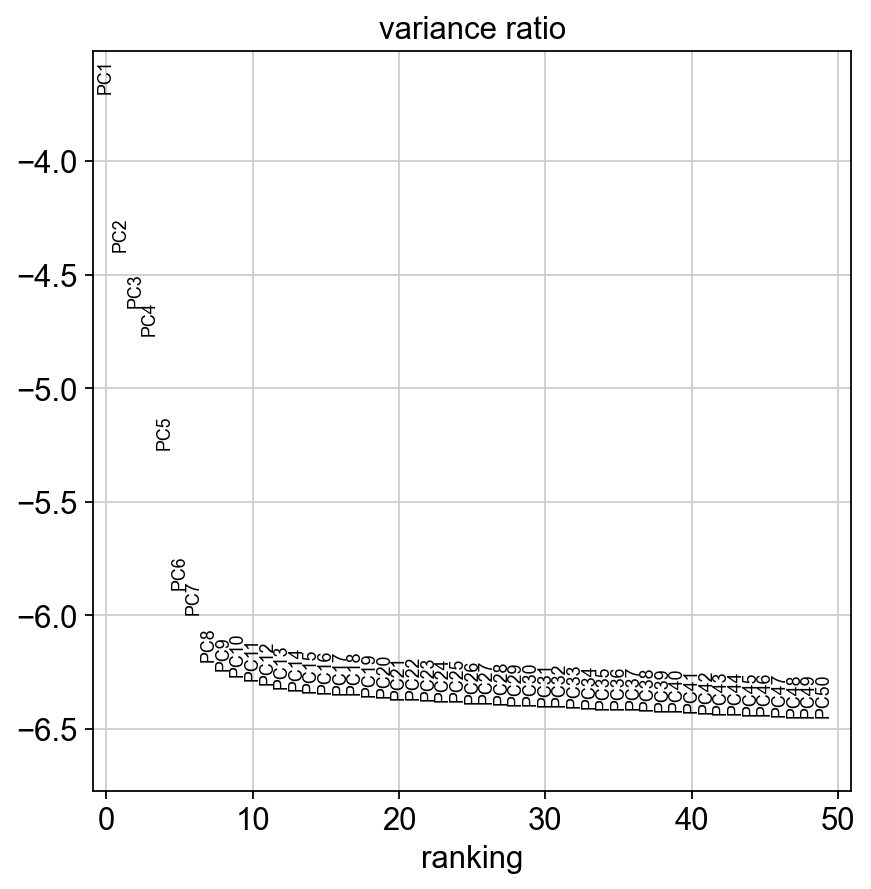


📊 Variance explained:
  - First 10 PCs: 7.1%
  - First 20 PCs: 8.9%
  - First 30 PCs: 10.6%
  - First 50 PCs: 13.8%


In [5]:
# Plot variance ratio
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50, show=False)
plt.savefig(f'{results_dir}03_pca_variance_ratio.png', dpi=150, bbox_inches='tight')
plt.show()

# Print cumulative variance
cumvar = np.cumsum(adata.uns['pca']['variance_ratio'])
print(f"\n📊 Variance explained:")
print(f"  - First 10 PCs: {cumvar[9]:.1%}")
print(f"  - First 20 PCs: {cumvar[19]:.1%}")
print(f"  - First 30 PCs: {cumvar[29]:.1%}")
print(f"  - First 50 PCs: {cumvar[49]:.1%}")

## 4. Elbow Plot - Choosing Number of PCs

The "elbow" is where variance explained starts to plateau. PCs after the elbow mostly capture noise.

**Rule of thumb**: Use PCs before the elbow.

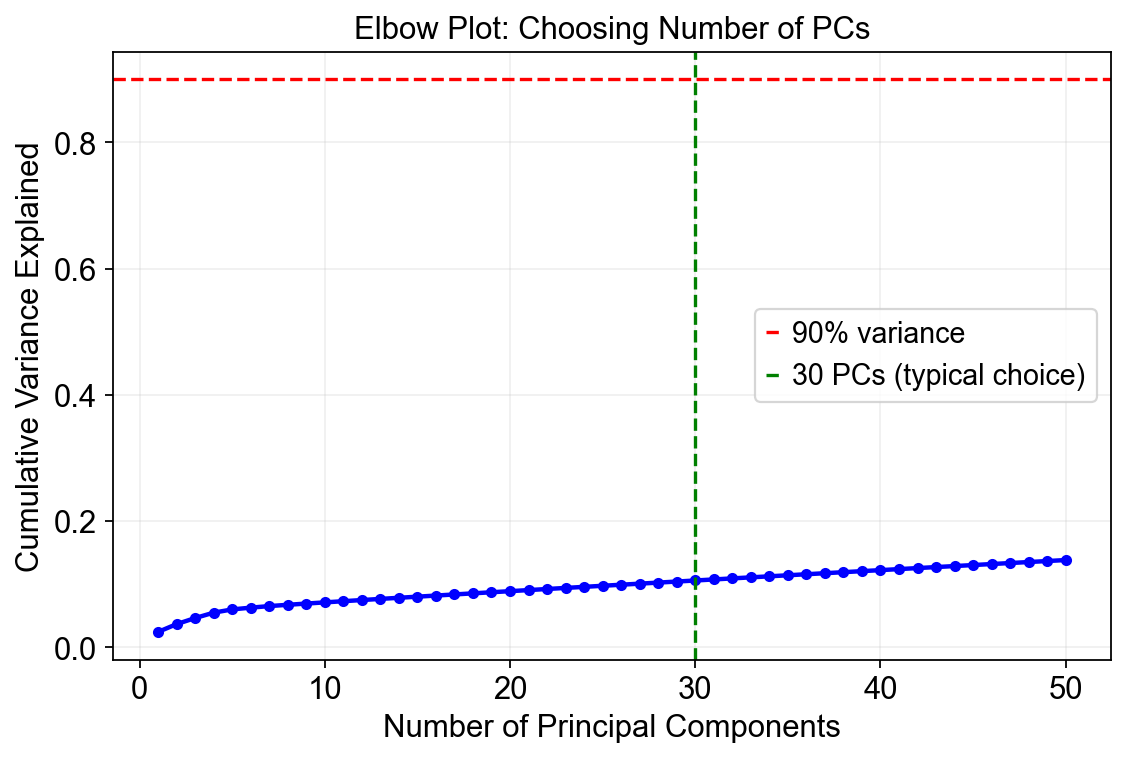

✅ Elbow plot created!
💡 Recommendation: Use ~30 PCs for downstream analysis


In [6]:
# Elbow plot
fig, ax = plt.subplots(figsize=(8, 5))

variance_ratio = adata.uns['pca']['variance_ratio']
cumulative_var = np.cumsum(variance_ratio)

ax.plot(range(1, 51), cumulative_var, 'bo-', linewidth=2, markersize=4)
ax.axhline(y=0.9, color='r', linestyle='--', label='90% variance')
ax.axvline(x=30, color='g', linestyle='--', label='30 PCs (typical choice)')
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Variance Explained')
ax.set_title('Elbow Plot: Choosing Number of PCs')
ax.legend()
ax.grid(True, alpha=0.3)

plt.savefig(f'{results_dir}03_pca_elbow_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Elbow plot created!")
print(f"💡 Recommendation: Use ~30 PCs for downstream analysis")